# Perros y Gatos con Convnets pre entrenados (feature extraction)

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Una de las características mas interesantes de los modelos convolucionales de clasificación de imágenes, es que se pueden reutilizar modelos pre entrenados con datasets suficientemente generales de mucho mayor tamaño, y aplicarlos a tareas de clasificación diferentes, que no disponen de un gran volúmen de datos. 

La idea es reutilizar las características (los *features*) espaciales aprendidos sobre un dataset general y de gran tamaño, ya que son abstracciones suficientemente generales para poder ser útiles para otros problemas, así estos involucren otras clases diferentes a las de la tarea original.

La portabilidad de las características a diferentes tipos de problemas es la base del **transfer learning** de modelos conexionistas, que constituye una ventaja sobre modelos de ML tradicionales, y permite aplicar el deep learning a problemas que no dispongan de datasets suficientemente grandes.

En este ejemplo vamos a considerar una Convnet entrenada sobre 1.4 millones de imágenes del dataset **Imagenet**, etiquetadas con 1000 clases, entre ellas diferentes clases de animales, por lo que probablemente funcione bien con el pequeño dataset de 25000 imágenes de perros y gatos de Kaggle.

Existen varios modelos disponibles gratuitamente para el transfer learning: VGG, Inception, ResNet, Inception-ResNet, Xception. Vamos a servirnos de una Convnet con arquitectura VGG16, desarrollada por Karen Simonyan y Andrew Zisserman en 2014, muy utilizada por su simple arquitectura, aunque un poco pesada (tamaño, número de parámetros). 

Hay dos maneras de reutilizar modelos pre entrenados, se pueden utilizar para hacer **feature extraction** sin tocar las capas convolucionales originales (lo que haremos aquí), o para hacer **fine tuning** que toma el modelo importado como base de inicialización y remodifica sus pesos según la tarea en cuestión.

## Feature extraction

El **feature extraction** consiste en utilizar las representaciones aprendidas por una red anterior como entradas sin modificar de un nuevo modelo de clasificación entrenado desde cero.

De los modelos originales se conservará entonces las salidas de las capas convolucionales, que luego se conectarán con capas densas fully connected. Los datos de la nueva tarea son entonces pasados por las capas convolucionales originales, cuya salida es luego "aplastada" en un tensor 1D que sirve como inputs de una red neuronal tradicional.

No se reutiliza las capas densas de los modelos originales, ya que son demasiado específicas a los problemas y clases originales con las que fueron entrenadas, sin contener información espacial de la ubicación de los conceptos aprendidos.
No son genéricas como lo son las capas convolucionales, que sirven como mapas de conceptos genéricos que podrían servir para todo tipo de problemas de computación visual.

El nivel de generalidad y reusabilidad de las representaciones extraídas por una capa convolucional específica depende de la profundidad de la misma. Las capas iniciales extraen conceptos locales mucho mas abstractos y altamente genéricos (lineas, esquinas, curvas), mientras que las capas finales extraen conceptos mas específicos (oreja de perro, nariz de gato). 

Es así como si la tarea de clasificación a la que se quiere transferir un modelo es muy diferente a la tarea original, puede ser mejor no utilizar todas las capas convolucionales, sino solo las primeras.

En este caso, como las clases de ImageNet comprendían últiples clases de perros y gatos, es provechoso reutilizar todas las capas convolucionales.

## Definición del modelo

Se va a reutilizar el modelo VGG16 que viene ya con Keras, pero que en todo caso hay que descargar de internet.
Se especifican los pesos que se quieren utilizar (los aprendidos con el dataset ImageNet), que no se quieren las capas densas (no se incluye la parte superior del modelo), y el tipo de inputs (imágenes en tensores de 150x150x3; por defecto se aceptaría cualquier tipo de imágenes).

In [1]:
import keras

Using TensorFlow backend.


In [27]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

El modelo tiene 14.7 millones de parámetros.

El tensor final tiene una forma (4, 4, 512), 512 filtros de "imágenes" de 4x4, las características que tienen que adaptarse para ser luego conectadas con una red densa fully connected.

Hay 2 maneras de proceder en este punto:
* Procesar el dataset de la tarea de destino pasándolo por la base convolucional, para luego grabar en disco el tensor final, que luego se puede cargar en una segunda etapa como los inputs de entrenamiento de una nueva red con la base fully connected. Esta solución es rápida y ahorradora en tiempo de ejecución, pues solo se utilizará la red convolucional una sola vez por cada imágen, la parte más consumidora de procesamiento, sin tener que repetirla por cada paso de entrenamiento. Pero esta técnica impide utilizar el **data augmentation**
* Extender el modelo convolucional de base importado, agregándole la subred fully connected, que serían las únicas capas que serían entrenadas. Esto permite el **data augmentation**, pero es mucho más costosa que la anterior.

## Feature extracción sin data augmentation  

Se va a procesar todo el dataset de test a través de la base convolucional importada, utilizando la función *predict*. La salida del dataset procesado se guardarán en memoria como un tensor de features maps que se aplanará para posteriormente ser procesado por una red densa shallow. [El preprocesamiento dura unos 20 minutos en un computador sin GPU].

In [28]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# El directorio con los particionamientos que utilizaremos para entrenar, validar y evaluar
base_dir = '/home/icesi/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/cats_and_dogs/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [29]:
# se utiliza un generador que convierte el tipo de los datos a float y reescala los inputs a [0,1] 
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# Esta función realiza el procesamiento de las imágenes de un directorio dado.
# Se define un número de imágenes deseado, pues los generadores son infinitos.
# Además puede servir para la extracción con un generador de data augmentation.
# Retorna tanto los tensores con los features como los labels correspondientes.
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Es necesario explicitar el break, ya que los generadores son infinitos en su generación
            break
    return features, labels

# Se transforman todos los dataset: train, validation y test.
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Las características extraídas son tensores de tipo (samples, 4, 4, 512), se van a aplanar a un tensor de tipo (samples, 8192).

In [30]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

En este punto se podrían grabar archivos para cada dataset procesado, así se pueden persistir para ser reutilizados varias veces en otras sesiones.

Ahora definimos la red fully connected con una capa final de clasificacón binaria con una función de activación sigmoide, agregando regularización a partir de una capa de Dropout al 50\%, y la entrenamos con 30 épocas.

In [31]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 291us/step - loss: 0.6179 - acc: 0.6615 - val_loss: 0.4504 - val_acc: 0.8080
Epoch 2/30
2000/2000 [==============================] - 0s 168us/step - loss: 0.4385 - acc: 0.7995 - val_loss: 0.3642 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 0s 160us/step - loss: 0.3653 - acc: 0.8425 - val_loss: 0.3221 - val_acc: 0.8620
Epoch 4/30
2000/2000 [==============================] - 0s 165us/step - loss: 0.3199 - acc: 0.8615 - val_loss: 0.2981 - val_acc: 0.8770
Epoch 5/30
2000/2000 [==============================] - 0s 170us/step - loss: 0.2863 - acc: 0.8860 - val_loss: 0.2824 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 0s 165us/step - loss: 0.2657 - acc: 0.8885 - val_loss: 0.2728 - val_acc: 0.8880
Epoch 7/30
2000/2000 [==============================] - 0s 168us/step - loss: 0.2547 - acc: 0.8940 - val_loss: 0.2664 - val_acc: 0.8960


El entrenamiento de esta red es bastante rápido, pues no se reentrenan las capas convolucionales y solo cuenta con 2 capas fully connected. Cada época dura unos pocos segundos.

Veamos los resultados del modelo.

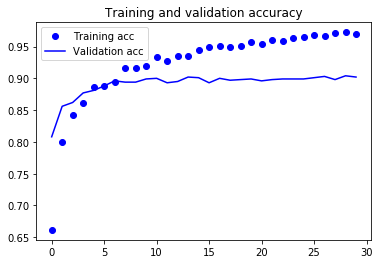

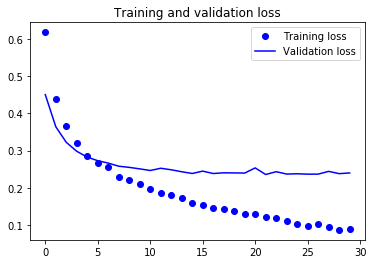

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Se llega a un nivel de exactitud de validación de aproximadamente 90%, superior al 86-87% del modelo entrenado desde cero. Sin embargo, se puede ver que se hace overfitting después de quinta época, aún depués de utilizar dropout. Esto nos lleva a buscar una mejora en los datasets, que puede que sean muy pequeños. Aplicamos entonces data augmentation para tratar de aliviar el problema.

## Feature extracción con data augmentation  

Ahora vamos a considerar una sola red, concatenando la base convolucional con la fully connected, permitiendo esto el **data augmentation**, pero siendo mucho más costosa en tiempo de ejecución, tanto que es inviable sin usar GPU.

Los modelos se comportan como capas, por lo que se va a construir un nuevo modelo secuencial agregando la base convolucional como una capa inicial. 

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


El modelo VGG16 tiene mas de 14,7 millones de parámetros (muy grande), y las capas fully connected tienen 2 millones.

Antes de compilar el modelo es importante configurar el modelo, especificando que la base convolucional no debe ser modificada durante le entrenamiento. "Congelarla" es necesario pués la base convolucional solo debe ser utilizada para extraer las características de los datos. De lo contrario, como las capas fully connected son incializadas aleatoriamente, actualizaciones muy grandes serían propagadas a la base convolucional durante el entrenamiento, destruyendo las representaciones previamente aprendidas.

In [36]:
conv_base.trainable = True
print('El número de capas a entrenar antes de congelar la parte convolucional es de: ', len(model.trainable_weights))
conv_base.trainable = False
print('El número de capas a entrenar despues de congeler la parte convolucional es de: ', len(model.trainable_weights))

El número de capas a entrenar antes de congelar la parte convolucional es de:  30
El número de capas a entrenar despues de congeler la parte convolucinales es de:  4


Al final solo se pueden entrenar las capas densas agregadas, proceso que se hará con **data augmentation** durante 30 épocas.

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Ojo: el entrenamiento de cada época dura entre 9 y 10 minutos en un computador sin GPU!! (Si se corre en CPU hay que pararlo, a menos que se tengan 5 horas para esperar el resultado...).

En GPUs el entrenamiento dura 6 minutos.

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 11s - loss: 0.5962 - acc: 0.6885 - val_loss: 0.4589 - val_acc: 0.8200
Epoch 2/30
 - 10s - loss: 0.4991 - acc: 0.7645 - val_loss: 0.3812 - val_acc: 0.8530
Epoch 3/30
 - 10s - loss: 0.4389 - acc: 0.8090 - val_loss: 0.3383 - val_acc: 0.8600
Epoch 4/30
 - 10s - loss: 0.4130 - acc: 0.8190 - val_loss: 0.3148 - val_acc: 0.8660
Epoch 5/30
 - 10s - loss: 0.3970 - acc: 0.8305 - val_loss: 0.2955 - val_acc: 0.8820
Epoch 6/30
 - 10s - loss: 0.3717 - acc: 0.8390 - val_loss: 0.2869 - val_acc: 0.8800
Epoch 7/30
 - 10s - loss: 0.3674 - acc: 0.8370 - val_loss: 0.2752 - val_acc: 0.8850
Epoch 8/30
 - 10s - loss: 0.3619 - acc: 0.8370 - val_loss: 0.2700 - val_acc: 0.8890
Epoch 9/30
 - 10s - loss: 0.3492 - acc: 0.8535 - val_loss: 0.2657 - val_acc: 0.8840
Epoch 10/30
 - 10s - loss: 0.3443 - acc: 0.8425 - val_loss: 0.2717 - val_acc: 0.8810
Epoch 11/30
 - 10s - loss: 0.3279 - acc: 0.8595 - val_loss: 0.2636 - val_acc: 0.8890
Epoch 12/30
 - 11s - loss: 0.3341 - acc: 0.8570 - val_loss: 0.2580 - val_a

Grabamos el modelo a disco

In [39]:
model_path = base_dir + "cats_and_dogs_small_3_ftext.h5"
model.save(model_path)

Evaluamos los resultados

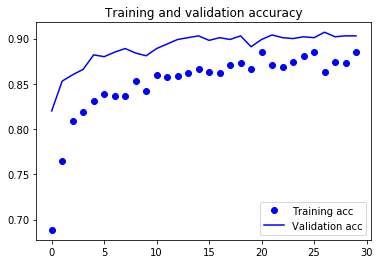

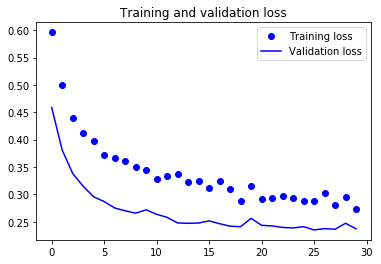

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Con este esquema llegamos al 96% de exactitud. Mucho mejor que los modelos precedentes.

## Fine-tuning

En este esquema de transfer learning, no se congela la totalidad del modelo importado. Se dejan libres las últimas capas para que adapten sus representaciones al dataset, haciéndolas mas relevantes al problema en cuestión y a las clases de la tarea de destino, reentrenàndose al mismo tiempo que se entrenan las capas fully connected agregadas.

Para no propagar las actualizaciones de gran magnitud iniciales de las capas fully connected a las capas convolucionales no congeladas, es necesario seguir el siguiente esquema:
1. Construir el modelo concatenando la base convolucional y las capas fully connected.
2. Congelar toda la base convolucional
3. Entrenar las capas fully connected para que sus pesos se "inicialicen" con valores adecuados y no se propaguen luego actualizaciones muy importantes a las capas convolucionales.
4. Descongelar las últimas capas convolucionales.
5. Entrenar de nuevo todas las capas entrenables al mismo tiempo, tanto las fully connected como las convolucionales liberadas.

Las primeras tres etapas ya se realizaron con el feature extraction sin data augmentation. Se continua con la cuarta y quinta etapas.

In [42]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

El quinto bloque convolucional incluye 3 capas, que son las que se van a liberar.
Primero se va a congelar toda la base convolucional, y luego se van a liberar las capas block5_conv1, block5_conv2 y block5_conv3 para que se puedan entrenar.

Dado que las abstracciones iniciales aprendidas por las primeras capsa son suficientemente genéricas cómo para necesitar adaptarse a la tarea de clasificación de destino. Es más útil reentrenar las capas más especializadas, adaptándolas al nuevo problema.

Entre más parámetros se tiene que entrenar, mayor el riesgo de overfitting. La base convolucional tiene 14.7 millones de parámetros. Entrenar más capas no es una buena idea, dado el tamaño pequeño del dataset. 

In [43]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [44]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Ahora vamos a entrenar el modelo a partir de los generadores.

In [46]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [48]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 12s 117ms/step - loss: 0.5687 - acc: 0.6955 - val_loss: 0.3726 - val_acc: 0.8380
Epoch 2/100
100/100 [==============================] - 10s 105ms/step - loss: 0.3856 - acc: 0.8250 - val_loss: 0.2537 - val_acc: 0.8870
Epoch 3/100
100/100 [==============================] - 11s 105ms/step - loss: 0.3326 - acc: 0.8525 - val_loss: 0.2245 - val_acc: 0.9060
Epoch 4/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2928 - acc: 0.8790 - val_loss: 0.2003 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 10s 105ms/step - loss: 0.2669 - acc: 0.8820 - val_loss: 0.2210 - val_acc: 0.9050
Epoch 6/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2453 - acc: 0.8945 - val_loss: 0.1927 - val_acc: 0.9170
Epoch 7/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2443 - acc: 0.9025 - val_loss: 0.1845 - val_acc: 0.9180
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0447 - acc: 0.9825 - val_loss: 0.2323 - val_acc: 0.9290
Epoch 62/100
100/100 [==============================] - 11s 111ms/step - loss: 0.0415 - acc: 0.9820 - val_loss: 0.2762 - val_acc: 0.9270
Epoch 63/100
100/100 [==============================] - 12s 120ms/step - loss: 0.0406 - acc: 0.9860 - val_loss: 0.2091 - val_acc: 0.9320
Epoch 64/100
100/100 [==============================] - 12s 118ms/step - loss: 0.0451 - acc: 0.9835 - val_loss: 0.2613 - val_acc: 0.9290
Epoch 65/100
100/100 [==============================] - 12s 117ms/step - loss: 0.0315 - acc: 0.9895 - val_loss: 0.2123 - val_acc: 0.9340
Epoch 66/100
100/100 [==============================] - 12s 120ms/step - loss: 0.0385 - acc: 0.9860 - val_loss: 0.2544 - val_acc: 0.9290
Epoch 67/100
100/100 [==============================] - 12s 119ms/step - loss: 0.0362 - acc: 0.9890 - val_loss: 0.2259 - val_acc: 0.9350
Epoch 68/100
100/100 [===================

Grabamos el modelo en disco

In [49]:
model_path = base_dir + "cats_and_dogs_small_4_FineTune.h5"
model.save(model_path)

Evaluamos los resultados

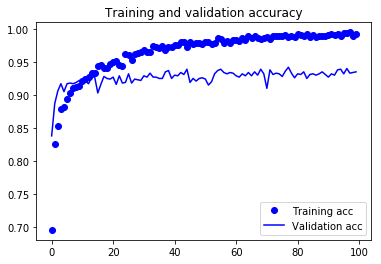

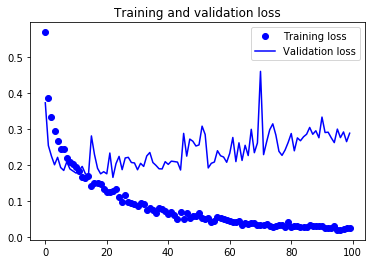

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Las curvas obtenidas son bastante ruidosas. Vamos a suivizarlas para que sea más fácil entrenarlas

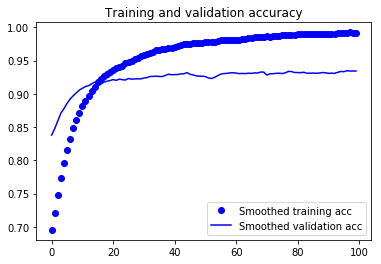

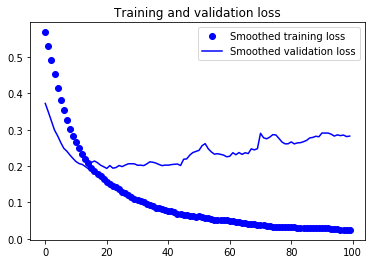

In [51]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

La curva de la pérdida no muestra ninguna mejora visible (de hecho parece que se está deteriorando).
Así parezca que se está mejorando en la exactitud, lo que realmente importa es la distribución de las funciones de perdida, lo que se muestra es el promedio de los valores puntuales de las funciones de perdida. Esto, dado que la exactitud es el resultado de un umbral de las probabilidades de las clases predichas por el modelo.

Se puede ahora evaluar el modelo aprendido con el dataset de test.

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9349999940395355


Tenemos una exactitud del 97%.

## Conclusión del uso de las Convnets

* Las convnets son los mejores modelos de machine learning para tareas de visión computacional. Se pueden obtener resultados decentes entrenando un modelo desde cero con un pequeño dataset.
* Con un pequeño dataset, el **overfitting** será el problema principal. **Data augmentation** es una técnica poderosa para combatirlo cuando se trabaja con imágenes.
* Es fácil reutilizar un modelo Convnet con un nuevo dataset, utilizandolo como extractor de características. El **transfer learning** ayuda mucho cuando se tienen pequeños datasets.
* el **fine tuning** puede utilizarse como complemento, adaptando algunas de las representaciones previamente aprendidas por un modelo importado y poder así mejorar el rendimiento del modelo actual un poco más